# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

In [103]:
customers = pd.read_csv('./arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [ ]:
#Remove the first unnamed column from both the azdias and customers dataframe
del azdias['Unnamed: 0']

In [104]:
del customers['Unnamed: 0']

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data
The DIAS attributes file contains a summary for each demographics data column. Assess the DIAS attributes file and look for any unknown or missing values. Once you find these values convert them to a list for each attribute type.

In [6]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx',sep=',')

In [7]:
feat_info.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [8]:
del feat_info['Unnamed: 0']

In [9]:
feat_info.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [10]:
# Forward fill the NaN for the attribute column
feat_info_new = feat_info['Attribute'].fillna(method='ffill')

In [11]:
feat_info['Attribute']=feat_info_new
feat_info.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [12]:
# Lets look at unknown or missing in the meaning column.
feat_info_meaning = feat_info[(feat_info['Meaning'].str.contains('unknown') | feat_info['Meaning'].str.contains('no'))]
feat_info_meaning

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
...,...,...,...,...
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [13]:
feat_info_meaning.loc[feat_info_meaning['Attribute']=='AGER_TYP','Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [14]:
missing_unknown = [ ]
for attrib in feat_info_meaning['Attribute'].unique():
    missing_unknown.append(feat_info_meaning.loc[feat_info_meaning['Attribute']== attrib,'Value'].astype(str).str.cat(sep=',').split(','))
    


In [15]:
missing_unknown = pd.concat([pd.Series(feat_info_meaning['Attribute'].unique()),pd.Series(missing_unknown)],axis=1)

In [16]:
missing_unknown.columns=['Attribute','missing_unknown']
missing_unknown .head()

,Attribute,missing_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


#### Step 1.1.1: Convert Missing Value codes to NaNs
Now that we have a data frame for missing value, we can convert the missing value code to NaNs. This file encodes this as a list(eg[-1,0]).Convert the 'missing' or 'unknown' to numpy NaN value.  

In [17]:
for i in missing_unknown['Attribute']:
    if i in azdias.columns:
        missing_map = missing_unknown.loc[missing_unknown['Attribute']== i,'missing_unknown'].iloc[0]
        idx = azdias.loc[:,i].isin(missing_map)
        azdias.loc[idx,i] = np.NaN
    else:
        continue
        

In [18]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [19]:
pickle.dump(azdias,open("azdias.pickle","wb"))

In [20]:
azdias = pickle.load(open("azdias.pickle","rb"))

#### Step 1.1.2: Assess Missing Data in each column

Let's look at missing data in each column. We will look for any outliers in terms of the proportion of values that are missing. A plot will help us visualize the missing data. Based on the proportion of missing data in each column a suitable action will be taken.

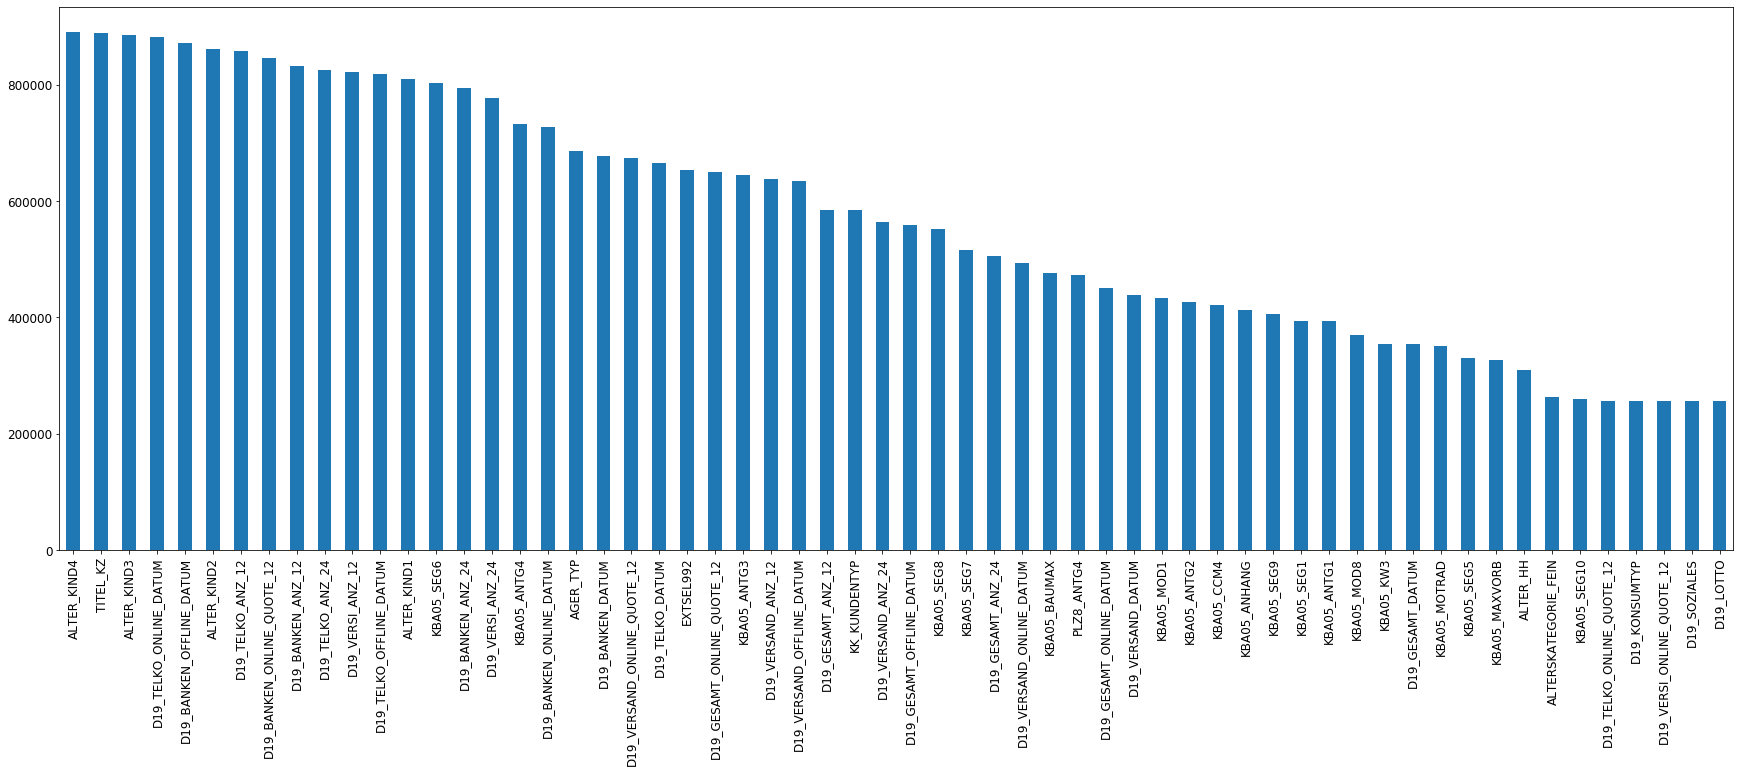

In [21]:
# Plot the number of missing data for column in descending order
azdias.isnull().sum().sort_values(ascending=False)[:60].plot(kind='bar',figsize=[30,10],fontsize=12)

In [22]:
azdias_missing_percent= azdias.isnull().sum()/len(azdias)*100

In [23]:
# Percentage of missing data in descending order. 
azdias_missing_percent.sort_values(ascending=False)[:50]

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
D19_TELKO_ONLINE_DATUM         99.079577
D19_BANKEN_OFFLINE_DATUM       97.791120
ALTER_KIND2                    96.690047
D19_TELKO_ANZ_12               96.271295
D19_BANKEN_ONLINE_QUOTE_12     94.924491
D19_BANKEN_ANZ_12              93.325225
D19_TELKO_ANZ_24               92.705176
D19_VERSI_ANZ_12               92.153237
D19_TELKO_OFFLINE_DATUM        91.909190
ALTER_KIND1                    90.904837
KBA05_SEG6                     90.071935
D19_BANKEN_ANZ_24              89.102479
D19_VERSI_ANZ_24               87.187914
KBA05_ANTG4                    82.302257
D19_BANKEN_ONLINE_DATUM        81.571462
AGER_TYP                       76.955435
D19_BANKEN_DATUM               76.112547
D19_VERSAND_ONLINE_QUOTE_12    75.680443
D19_TELKO_DATUM                74.706274
EXTSEL992                      73.399639
D19_GESAMT_ONLINE_QUOTE_12     72.954744
KBA05_ANTG3     

In [24]:
# Print the percentage of columns which has missing values greater than certain percentage. 
#This will help to identify how many columns can be dropped based on the percentage of missing data.
for i in range(0,90,10):
    print('columns having missing values >{}% : {}'.format(i,len(azdias_missing_percent[azdias_missing_percent>i])))

columns having missing values >0% : 301
columns having missing values >10% : 268
columns having missing values >20% : 98
columns having missing values >30% : 53
columns having missing values >40% : 47
columns having missing values >50% : 38
columns having missing values >60% : 32
columns having missing values >70% : 27
columns having missing values >80% : 18


In [25]:
missing_data = azdias.isnull().sum()

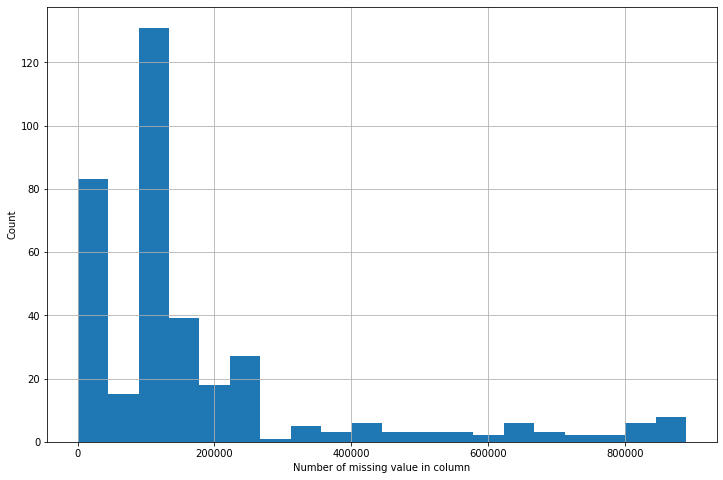

In [26]:
# Investigate patters in the amount of missing data in each column.
plt.figure(figsize=[12,8])
plt.hist(missing_data,bins=20)
plt.xlabel("Number of missing value in column")
plt.ylabel("Count")
plt.grid(True)

In [27]:
columns_dropped = missing_data[missing_data>300000]
azdias_new = azdias.drop(columns_dropped.index,axis=1)

In [83]:
columns_dropped.index

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_CCM4', 'KBA05_KW3',
       'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_MOTRAD',
       'KBA05_SEG1', 'KBA0

A total of 53 columns were dropped. These columns had a missing value greater than 300000. 

#### Step1.1.3: Assess Missing Data in Each Row
We will perform similar assessemnt for rows of dataset. We will look at missing in each row and divide the data into two subsets: one for data points that are above some threshold for missing values and other for points below that threshold. We will visualize the missing value in row with seaborn or matplotlib.

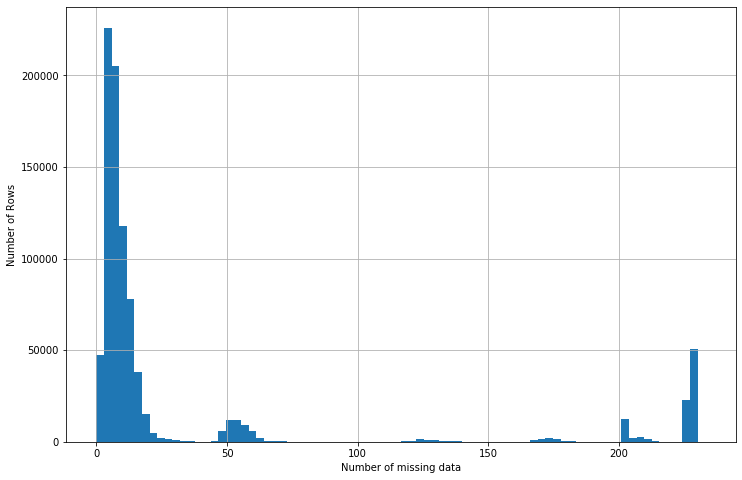

In [29]:
missing_each_row = azdias_new.isnull().sum(axis=1)
plt.figure(figsize=[12,8])
plt.hist(missing_each_row,bins=80)
plt.xlabel("Number of missing data")
plt.ylabel("Number of Rows")
plt.grid(True)

In [30]:
azdias_missing_upper = azdias_new[missing_each_row>=25]
azdias_missing_lower = azdias_new[missing_each_row<25]
azdias_missing_lower.shape

(733087, 313)

Initially, the data frame had 366 columns and 891221 rows. After dropping the rows and columns the new data fram has 313 columns and 733087 rows.

### Step1.2: Select and Re-Encode Features

We will work on the following encoding:
* Numeric or interval data will be kept without changes
* Ordinal data which maybe non-linear in spacing, we will make an assumptipon to handel the ordinal data. An assumption would be treating an ordinal data as having an interval.
* Categorial and mixed data will be handled.


In [47]:
num_cols = azdias_missing_lower.select_dtypes(include='int').columns
cat_cols = azdias_missing_lower.select_dtypes(include = 'object').columns


In [45]:
azdias_missing_lower.select_dtypes(include = 'object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


In [61]:
azdias_missing_lower.select_dtypes(include='int').head()
    

,LNR,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,GEBURTSJAHR,GREEN_AVANTGARDE,KOMBIALTER
1,910220,0,0,0,0,0,0,0,0,0,...,0,10,10,10,0,0,0,1996,0,1
2,910225,0,0,0,0,0,0,6,0,0,...,0,10,10,10,0,7,0,1979,1,2
3,910226,0,0,0,0,0,0,0,0,6,...,0,10,10,10,0,0,0,1957,0,4
4,910241,1,2,0,6,6,1,6,0,6,...,2,2,7,10,3,0,0,1963,0,3
5,910244,0,0,0,0,0,0,0,0,0,...,0,8,10,10,6,0,0,1943,0,4


In [64]:
azdias_missing_lower.select_dtypes(include ='float').head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [60]:
for feat in cat_cols:
    print("The list of feature values in {} are:{}".format(feat,azdias_missing_lower[feat].unique()))

The list of feature values in CAMEO_DEU_2015 are:['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F'
 '1C' 'XX']
The list of feature values in CAMEO_DEUG_2015 are:[8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1' 'X']
The list of feature values in CAMEO_INTL_2015 are:[51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 41.0 34.0 55.0 33.0 25.0 nan
 23.0 31.0 52.0 45.0 35.0 44.0 32.0 '24' '41' '12' '51' '44' '35' '23'
 '25' '14' '34' '52' '55' '31' '32' '22' '15' '13' '43' '45' '33' '54'
 'XX']
The list of feature values in D19_LETZTER_KAUF_BRANCHE are:[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_SONSTIGE' 'D19_BANKEN_GROSS' 'D19_VOLLSORTIMENT'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BAN

In [65]:
azdias_missing_lower['OST_WEST_KZ'].replace(['W',"O"],[1,0],inplace = True)

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [70]:
azdias_missing_lower['CAMEO_INTL_2015'] = azdias_missing_lower['CAMEO_INTL_2015'].replace(['XX'],np.nan)

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
# Investigate "CAMEO_INTL_2015" and add two new colunms(Life and wealth)
def wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])
def life(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])
azdias_missing_lower['CAMEO_INTL_2015_WEALTH']=azdias_missing_lower['CAMEO_INTL_2015'].apply(wealth)
azdias_missing_lower['CAMEO_INTL_2015_LIFE']=azdias_missing_lower['CAMEO_INTL_2015'].apply(life)    

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [73]:
azdias_missing_lower.drop('CAMEO_INTL_2015',axis = 1,inplace = True)

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [75]:
azdias_missing_lower['CAMEO_DEUG_2015'] = azdias_missing_lower['CAMEO_DEUG_2015'].replace(['X'],np.nan)

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
cols_dropped= ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']

In [77]:
azdias_missing_lower.drop(cols_dropped,axis=1,inplace = True)

In [79]:
azdias_missing_lower.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,5.0,1.0
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,2.0,4.0
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,1.0,2.0
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,4.0,3.0
5,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0,5.0,4.0


### Step 1.3 : Create cleaning function
We will put together all the process as a single function to use it for the customer demographic data. This will help to clean the customer dataset in a single step.

In [105]:
def clean_data(df,df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Convert missing value into np.nan
    for i in df2['Attribute']:
        if i in df.columns:
            missing_map = df2.loc[missing_unknown['Attribute']== i,'missing_unknown'].iloc[0]
            idx = df.loc[:,i].isin(missing_map)
            df.loc[idx,i] = np.NaN
        else:
            continue
        # remove the columns with missing values greater than 300000 for the azdias dataframe
    cols_dropped = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'EXTSEL992', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_CCM4', 'KBA05_KW3',
       'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_MOTRAD',
       'KBA05_SEG1', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8',
       'KBA05_SEG9', 'KK_KUNDENTYP', 'PLZ8_ANTG4', 'TITEL_KZ']
    df.drop(cols_dropped,axis = 1,inplace = True)
    #remove the rows with missing values greater than 25 for azdias dataframe
    missing_each_row = df.isnull().sum(axis=1)
    df = df[missing_each_row<25]
    # select and re-encode 
    df['OST_WEST_KZ'].replace(['W',"O"],[1,0],inplace = True)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace(['XX'],np.nan)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace(['X'],np.nan)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['CAMEO_INTL_2015_LIFE'] = df['CAMEO_INTL_2015'].apply(life)
    df.drop('CAMEO_INTL_2015',axis = 1,inplace = True)
    cols_cat_drop = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']
    df.drop(cols_cat_drop, axis = 1, inplace = True)
        
    # return a cleaned dataframe
    return df
        
        
        
        
    

In [106]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [107]:
customers_clean = clean_data(customers,missing_unknown)

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [108]:
customers_clean.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,9626,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0,1.0,3.0
2,143872,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0,3.0,4.0
3,143873,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0,2.0,4.0
4,143874,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0,4.0,1.0
5,143888,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,9.0,1.0,2.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,3.0,3.0,4.0


In [109]:
azdias_missing_lower.shape[1],customers_clean.shape[1]

(311, 314)

In [114]:
customers_col_diff = set(customers_clean.columns)-set(azdias_missing_lower.columns)
customers_col_diff

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [115]:
# Lets drop these additional columns from customer data to get same number of columns as azdias dataframe
customers_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis = 1, inplace = True)

In [119]:
# Impute the missing values
from sklearn.preprocessing import Imputer
imp = Imputer(strategy = 'most_frequent',axis=0)
azdias_cleaned_imputed = pd.DataFrame(imp.fit_transform(azdias_missing_lower))
customers_clean_imputed = pd.DataFrame(imp.fit_transform(customers_clean))
azdias_cleaned_imputed.head(),customers_clean_imputed.head()

/Users/sunilthapa/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(        0    1     2     3    4    5    6     7    8    9    ...   301   302  \
 0  910220.0  9.0  21.0  11.0  0.0  0.0  2.0  12.0  0.0  3.0  ...  11.0  10.0   
 1  910225.0  9.0  17.0  10.0  0.0  0.0  1.0   7.0  0.0  3.0  ...   9.0   6.0   
 2  910226.0  1.0  13.0   1.0  0.0  0.0  0.0   2.0  0.0  2.0  ...  10.0  11.0   
 3  910241.0  1.0  14.0   3.0  0.0  0.0  4.0   3.0  0.0  4.0  ...   5.0   4.0   
 4  910244.0  1.0  10.0   5.0  0.0  0.0  1.0   2.0  0.0  2.0  ...   7.0   4.0   
 
    303  304  305  306  307  308  309  310  
 0  3.0  9.0  4.0  5.0  2.0  1.0  5.0  1.0  
 1  3.0  9.0  2.0  5.0  2.0  3.0  2.0  4.0  
 2  6.0  9.0  7.0  3.0  2.0  4.0  1.0  2.0  
 3  2.0  9.0  3.0  4.0  1.0  3.0  4.0  3.0  
 4  6.0  9.0  7.0  4.0  2.0  1.0  5.0  4.0  
 
 [5 rows x 311 columns],
         0    1     2    3    4    5    6    7    8    9    ...   301   302  \
 0    9626.0  1.0  10.0  1.0  0.0  0.0  2.0  1.0  0.0  1.0  ...   3.0   2.0   
 1  143872.0  1.0   0.0  1.0  0.0  0.0  1.0  1.0  0.0  3.

In [123]:
azdias_cleaned_imputed.columns = azdias_missing_lower.columns
azdias_cleaned_imputed.index = azdias_missing_lower.index
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index


In [124]:
azdias_cleaned_imputed.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
1,910220.0,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,5.0,1.0
2,910225.0,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,2.0,4.0
3,910226.0,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,10.0,11.0,6.0,9.0,7.0,3.0,2.0,4.0,1.0,2.0
4,910241.0,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,4.0,3.0
5,910244.0,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0,5.0,4.0


In [128]:
customers_clean_imputed.isnull().sum().sum(),azdias_cleaned_imputed.isnull().sum().sum()

(0, 0)

Both the customers and azdias data frame does not have null values. Most frequent or mode was used to impute the missing values. 

### Step 1.3: Apply Feature Scaling 

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.A StandardScaler will be used to scale each feature to mean 0 and standard deviation 1.

In [134]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_cleaned_imputed)
azdias_scaled=pd.DataFrame(azdias_scaled,columns=list(azdias_cleaned_imputed))
azdias_scaled.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,1.057747,1.260723,1.559928,0.187455,-0.125266,-0.299061,0.224540,0.336205,-0.060474,-0.182974,...,1.066831,1.461703,-0.747118,0.547767,-0.028706,1.141155,0.958491,-1.680905,1.16824,-1.248259
1,1.057767,1.260723,0.673650,0.121210,-0.125266,-0.299061,-0.634483,-0.031477,-0.060474,-0.182974,...,0.453089,0.028347,-0.747118,0.547767,-1.083163,1.141155,0.958491,0.168635,-0.87743,0.763740
2,1.057771,-0.935348,-0.212629,-0.474998,-0.125266,-0.299061,-1.493506,-0.399160,-0.060474,-1.187039,...,0.759960,1.820042,0.952827,0.547767,1.552978,-0.279728,0.958491,1.093405,-1.55932,-0.577593
3,1.057829,-0.935348,0.008941,-0.342508,-0.125266,-0.299061,1.942586,-0.325623,-0.060474,0.821090,...,-0.774393,-0.688330,-1.313767,0.547767,-0.555934,0.430714,-1.043307,0.168635,0.48635,0.093073
4,1.057840,-0.935348,-0.877338,-0.210017,-0.125266,-0.299061,-0.634483,-0.399160,-0.060474,-1.187039,...,-0.160652,-0.688330,0.952827,0.547767,1.552978,0.430714,0.958491,-1.680905,1.16824,0.763740


In [130]:
customers_scaled = scaler.fit_transform(customers_clean_imputed)
customers_scaled=pd.DataFrame(customers_scaled,columns=list(customers_clean_imputed))
customers_scaled.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,-1.560315,-0.355005,-0.061996,-0.273259,-0.124546,-0.265873,-0.208546,-0.256772,-0.134615,-1.812721,...,-0.525356,-0.502840,0.868465,0.274851,1.581332,0.465416,-0.697761,0.650711,-1.127343,-0.281074
1,0.864370,-0.355005,-2.545450,-0.273259,-0.124546,-0.265873,-0.922776,-0.256772,-0.134615,0.170761,...,2.953359,3.582333,0.868465,0.274851,-0.836947,0.465416,1.433156,0.650711,0.295909,0.466494
2,0.864388,-0.355005,-0.558687,-0.345945,-0.124546,-0.265873,-1.637006,-0.256772,-0.134615,-1.812721,...,-0.177485,-0.502840,0.868465,0.274851,1.581332,-1.070787,-0.697761,0.650711,-0.415717,0.466494
3,0.864406,-0.355005,0.931385,0.162857,-0.124546,-0.265873,1.219914,0.185512,-0.134615,0.170761,...,0.170387,0.404977,-1.278772,0.274851,-0.353292,-1.070787,-0.697761,-0.673456,1.007535,-1.776211
4,0.864659,-0.355005,-0.061996,-0.273259,-0.124546,-0.265873,-0.208546,-0.256772,-0.134615,0.170761,...,-0.873228,-0.956748,0.868465,0.274851,-1.320603,-0.302686,-0.697761,-0.673456,0.295909,0.466494


In [131]:
# Dump both the azdias and cusomters scaled dataframe 
pickle.dump(azdias_scaled,open("azdias_new.pickle","wb"))
pickle.dump(customers_scaled,open("customers_new.pickle","wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [133]:
azdias_new = pickle.load(open("azdias_new.pickle","rb"))
customers_new = pickle.load(open("customers_new.pickle","rb"))

### Perform Dimensionality Reduction
* Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
* Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's plot() function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
* Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [135]:
from sklearn.decomposition import PCA
pca=PCA()
azdias_pca=pca.fit(azdias_new)

In [136]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:3])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=4)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


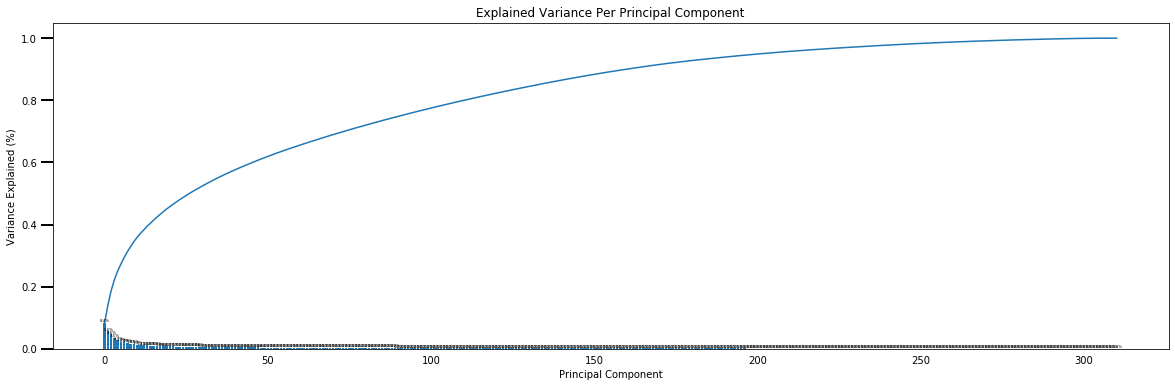

In [137]:
scree_plot(pca)

In [142]:
pca_250 = PCA(n_components = 250)
azdias_pca_250 = pca_200.fit_transform(azdias_new)

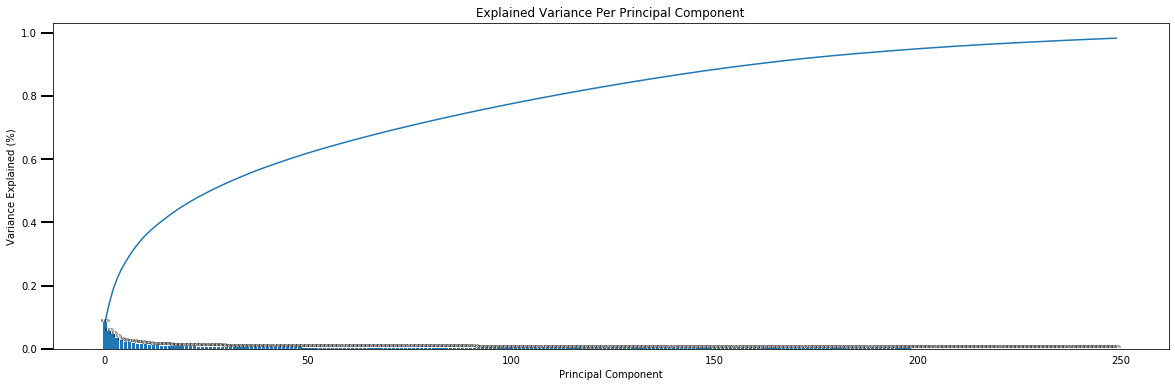

In [141]:
scree_plot(pca_250)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')